<a href="https://colab.research.google.com/github/gennadygorin/seq-cme-technoise/blob/dev/gg220406_refactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

slowly but surely


In [ ]:
from datetime import datetime
import os
code_ver_global='020'
import logging
import sys

logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.DEBUG)

In [ ]:
%%capture
!pip install loompy

In [ ]:
import loompy as lp

In [ ]:

import collections
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import csv

In [ ]:
dataset_names = ['pbmc_1k_fbc','pbmc_1k_v3'] 
loom_filepaths = ['./'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = 'gg_200525_genome_polyA_cum_3'
attribute_names=[['spliced','unspliced','Gene','CellID'],['spliced','unspliced','gene_name','barcode']]

In [ ]:
from preprocess import *

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
import pickle
import time

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./gg_220409_020_batch_1 created.
INFO:root:Dataset: pbmc_1k_fbc
INFO:root:1305 cells detected.
INFO:root:64792 features observed, 55712 match genome annotations. 52809 were unique.
INFO:root:2694 genes retained after expression filter.
INFO:root:Directory ./gg_220409_020_batch_1/pbmc_1k_fbc created.
INFO:root:Dataset: pbmc_1k_v3
INFO:root:1200 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:3089 genes retained after expression filter.
INFO:root:Directory ./gg_220409_020_batch_1/pbmc_1k_v3 created.
INFO:root:Gene set size: 1961
INFO:root:100 genes selected.
INFO:root:Directory ./gg_220409_020_batch_1/diagnostic_figures created.


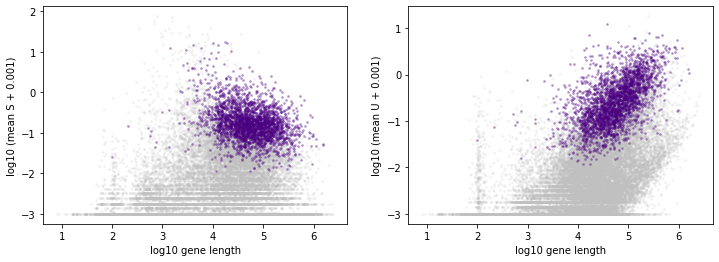

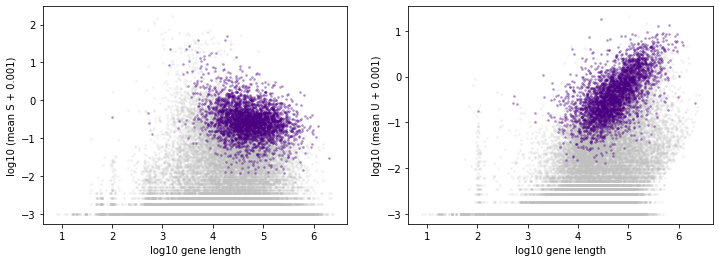

In [ ]:
!rm -r gg_*/
dir_string,dataset_strings = construct_batch(loom_filepaths, transcriptome_filepath, dataset_names, attribute_names=attribute_names)

In [ ]:
from extract_data import extract_data

INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_1k_fbc
INFO:root:64792 features observed, 55712 match genome annotations. 52809 were unique.
INFO:root:Gene list extracted from ./gg_220409_020_batch_1/genes.csv.
INFO:root:Directory ./gg_220409_020_batch_1/pbmc_1k_fbc/diagnostic_figures created.
INFO:root:Search data stored to ./gg_220409_020_batch_1/pbmc_1k_fbc/raw.sd.


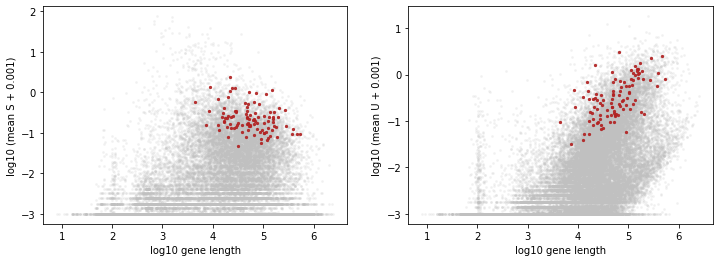

In [ ]:

for j in range(1):
    search_data = extract_data(loom_filepaths[j], transcriptome_filepath, dataset_names[j],
                        dataset_strings[j], dir_string, dataset_attr_names=attribute_names[j])

In [ ]:
from cme_toolbox import CMEModel

In [ ]:
fitmodel = CMEModel('Bursty','Poisson')

In [ ]:
from inference import InferenceParameters, GradientInference

In [ ]:
inference_parameters = InferenceParameters([-1, -1.8, -1.8 ],\
                [4.2, 2.5, 2.5],[-8, -3.5],[-3, 1 ],[5,5],\
                dataset_strings[j],fitmodel)
# inference_parameters.construct_grid()

INFO:root:Directory ./gg_220409_020_batch_1/pbmc_1k_fbc/Bursty_Poisson_5x5 created.
INFO:root:Global inference parameters stored to ./gg_220409_020_batch_1/pbmc_1k_fbc/Bursty_Poisson_5x5/parameters.pr.


In [ ]:
grad_inference = GradientInference(inference_parameters,search_data,fitmodel,0)

In [ ]:
param_estimates, klds, obj_func, d_time = grad_inference.iterate_over_genes(fitmodel,search_data)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


In [ ]:
grad_inference.param_MoM[:10]

array([[3.87344232, 0.46910243, 0.52763175],
       [3.74024018, 0.79160961, 0.99791585],
       [3.95511923, 0.57231916, 1.06018473],
       [3.96914158, 1.38462067, 1.35430317],
       [2.69309503, 0.50412074, 0.23315859],
       [3.33576893, 0.77774024, 0.5896516 ],
       [3.59844224, 0.68247172, 0.92849546],
       [3.45191056, 0.66581732, 0.32794874],
       [3.40100056, 0.57138646, 0.61693734],
       [3.74456265, 0.99154782, 1.03795384]])

In [ ]:
param_estimates[:10]

array([[4.09878043, 0.6707252 , 0.76485696],
       [3.96553072, 0.99197471, 1.24395716],
       [4.07350106, 0.68854664, 1.1867114 ],
       [3.66215366, 1.18674664, 0.93229714],
       [2.77371845, 0.57443764, 0.34378045],
       [3.39990129, 0.84164764, 0.65714534],
       [3.67603898, 0.75971269, 1.02050103],
       [3.90819982, 1.05131551, 0.80683985],
       [3.47426597, 0.6426369 , 0.69715234],
       [3.57911932, 0.83001845, 0.86929678]])

In [ ]:
transcriptome_dict = get_transcriptome(transcriptome_filepath)

In [ ]:
j=0
_,_,names,_ = import_vlm(loom_filepaths[j],*attribute_names[j])

In [ ]:
names

array(['DDX11L1', 'WASH7P', 'MIR6859-1', ..., 'AC007325.1', 'AC007325.4',
       'AC007325.2'], dtype=object)

In [ ]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.warning('I print to stderr by default')
log.debug('A debug message!')
log.info('We processed %d records', 20)


DEBUG:root:A debug message!
INFO:root:We processed 20 records


In [ ]:
import logging
logger = logging.getLogger()
logging.debug("test")


DEBUG:root:test


In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [ ]:
from datetime import date
import time
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
!pip -q install numdifftools 
!pip -q install parfor
!pip -q install loompy

     |████████████████████████████████| 99 kB 2.8 MB/s 
     |████████████████████████████████| 189 kB 17.0 MB/s 
     |████████████████████████████████| 4.8 MB 5.1 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts. The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [ ]:
!rm -r *

In [ ]:
!git clone --branch dev https://github.com/gennadygorin/seq-cme-technoise

Cloning into 'seq-cme-technoise'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 407 (delta 127), reused 148 (delta 74), pack-reused 199
Receiving objects: 100% (407/407), 53.58 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [ ]:
# !git branch -a

In [ ]:
!mv seq-cme-technoise/* .
!mv polyA_ref/* .


Import the processing scripts.

In [ ]:
from cme_toolbox import *

In [ ]:
model = CMEModel(bio_model='Delay',seq_model='Bernoulli',quad_method='quad_vec')

In [ ]:
p = np.asarray([1,0.5,0.2])
limits = np.asarray([20,20])
# samp = np.asarray([-1.0,-1.0])
samp = np.asarray([0.9,0.2])

In [ ]:
P = model.eval_model_pss(p,limits,samp)

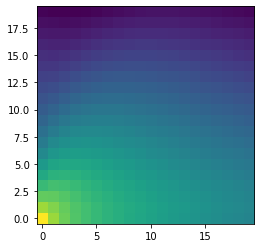

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(P).T)
plt.gca().invert_yaxis()

## Inference

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [ ]:
!cat loom_fbc/example_input.txt

#Parameter input for CME inference 
dataset_directory : ./loom_fbc/ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames : pbmc_1k_fbc : filenames to integrate
transcriptome_filename : gg_200525_genome_polyA_cum_3 : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','CellID']]*2 : list or list of lists with loom attribute names
gene_sel_seed : 123 : gene selection seed
n_gen : 100 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list : : set of result files to import to define gene names
phys_lb : -1, -1.8, -1.8 : log10 of lower bound on burst

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

['./loom_fbc/pbmc_1k_fbc.loom']
Beginning preprocessing routine:
Dataset: ./loom_fbc/pbmc_1k_fbc.loom
64792 features observed, 55712 match genome annotations. 52809 are unique. 
1305 cells detected.
24426 genes retained as high-expression.
2684 genes retained in loom structure based on filter.
Gene set size: 2684
-----------
100 genes selected.
Gene set selected!
Beginning search routine.
64792 features observed, 55712 match genome annotations. 52809 are unique. 
1305 cells detected.
Directory ./gg_220406_pbmc_1k_fbc_5x6_100gen_1 created; metadata written.
30 of 30 points to be evaluated.
Starting search...


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Parallelization done!


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Runtime: 1.6 min.


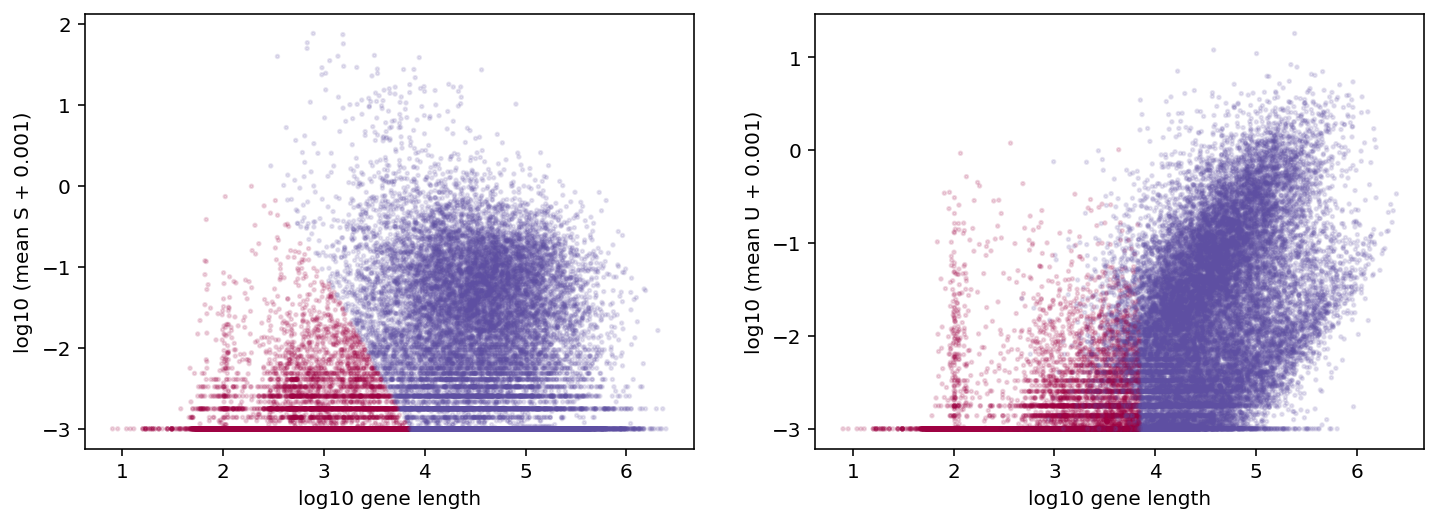

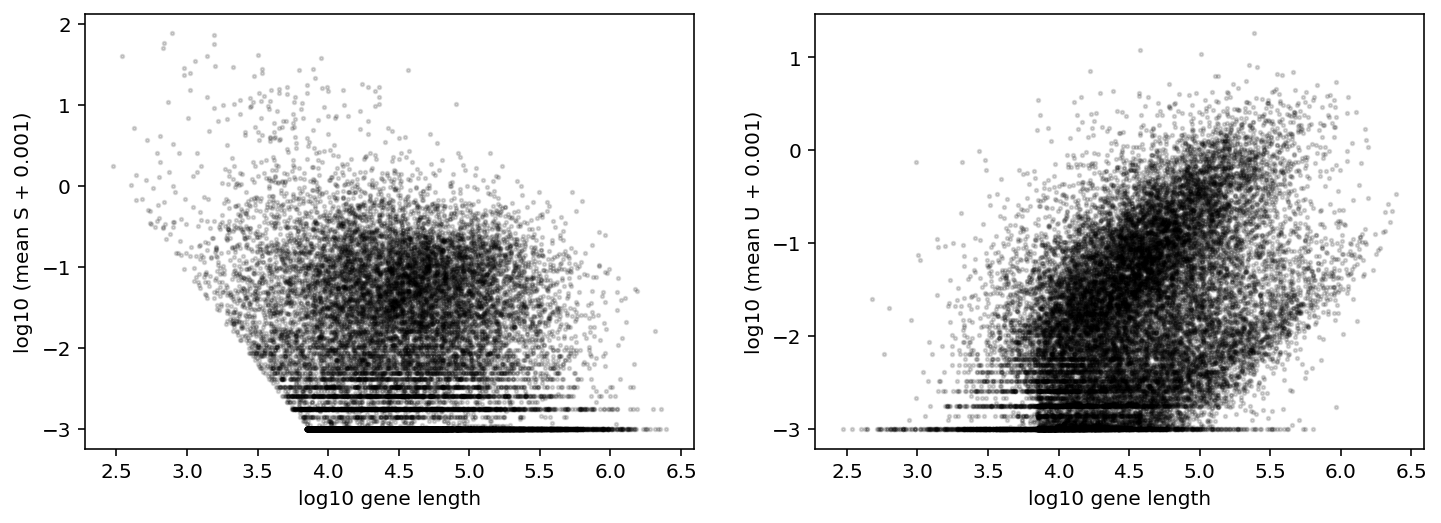

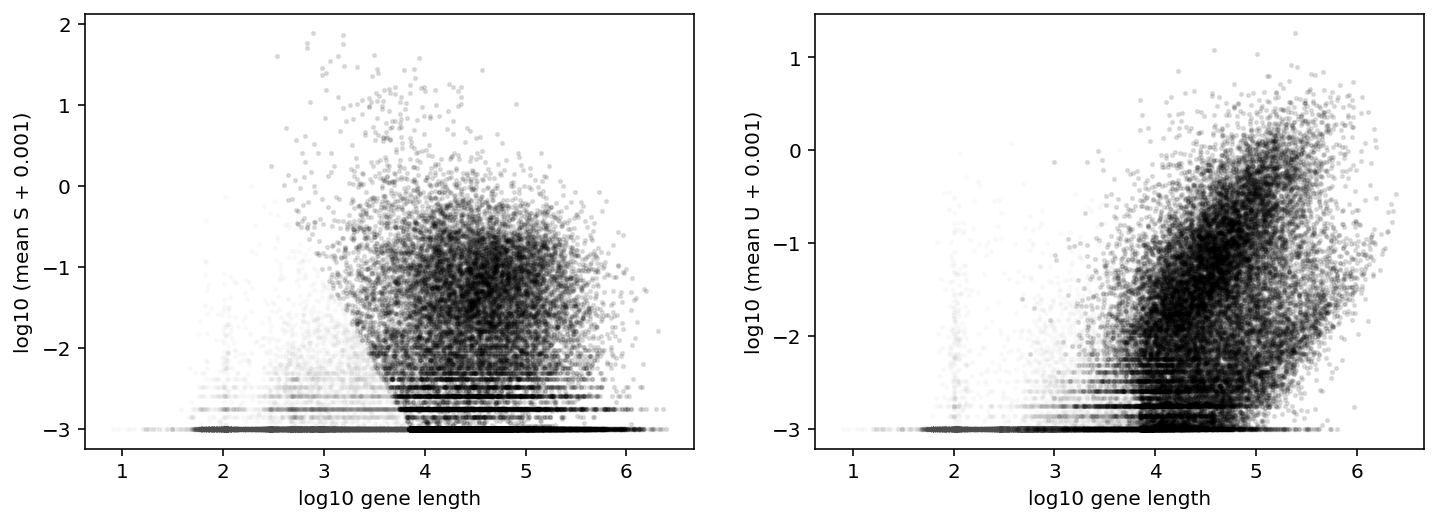

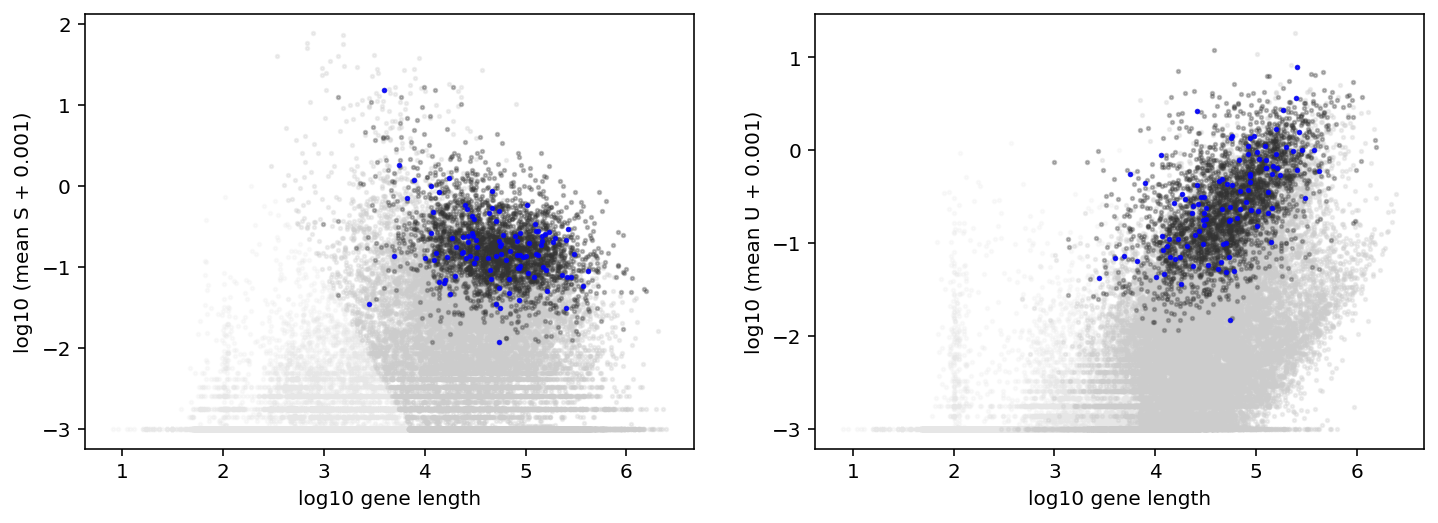

In [ ]:
inference_workflow('loom_fbc/example_input.txt')

## Result processing

### Data summary and exploration

Import the results. This interface can accept multiple inputs: for example, it's possible to use the same grid for searches over several sets of genes and integrate them in downstream analysis. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [ ]:
result_data = import_datasets(['./gg_{}_pbmc_1k_fbc_5x6_100gen_1/result.pickle'.format(date.today().strftime("%y%m%d"))])

Visualize the sampling parameter landscape. There is clearly an optimal basin in the $C_u, \lambda_s$ space, although the low resolution of the scan and the  number of genes make it challenging to identify it with much confidence.

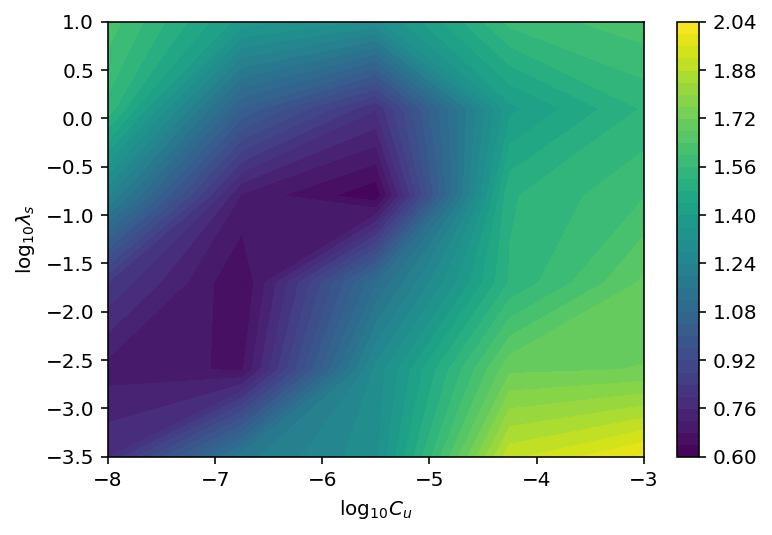

In [ ]:
landscape_viz(result_data)

Compute the best parameter tuple using simple total KL divergence minimization. 

In [ ]:
result_data.find_best_params()

In [ ]:
result_data.best_samp_params

(-5.5, -0.7999999999999998)

Test the stability of the parameter optimum under resampling. Essentially, we subsample sets of genes and see how the landscape and its optimum change. The basin appears to be robust and well-defined with as few as 20 genes.

In [ ]:
resamp_vec = np.array(np.linspace(0,result_data.n_gen,6)[1:-1],dtype=int)

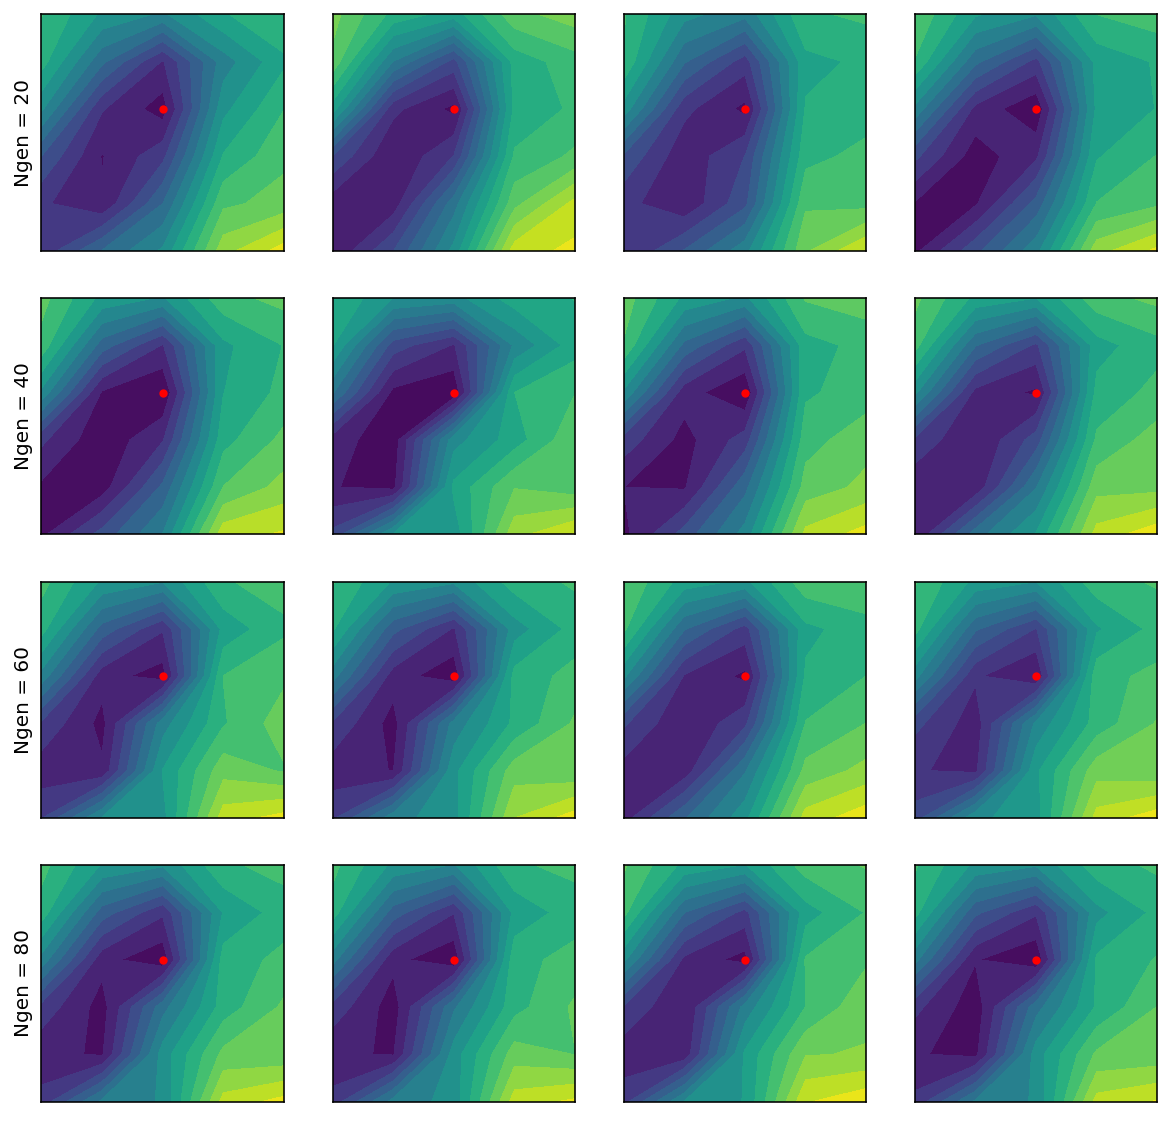

In [ ]:
resample_opt_viz(result_data,resamp_vec)

Summarize these findings by resampling 1000 times and plotting the locations of the optima.

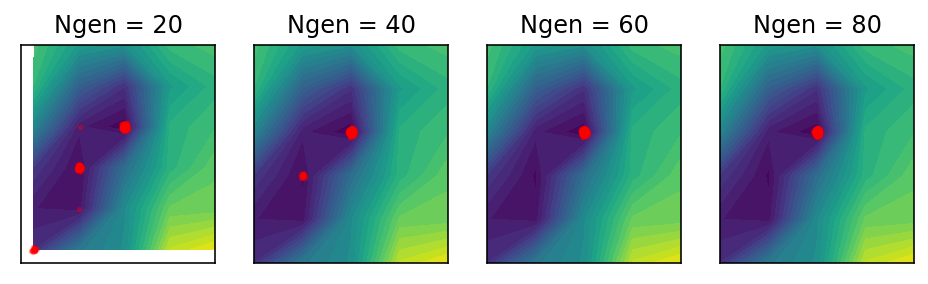

In [ ]:
resample_opt_mc_viz(result_data,resamp_vec)

Plot a normal-inverse Gaussian fit to the parameters, with and without sampling. The parameters clearly show quite a bit of skewness.

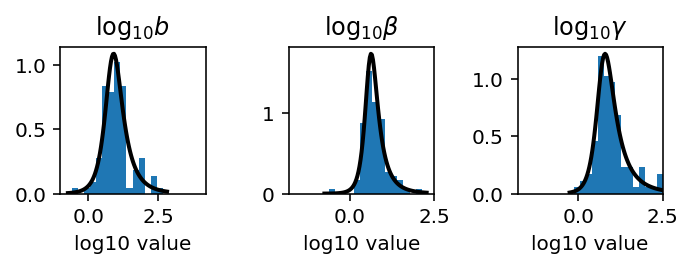

In [ ]:
from scipy.stats import *
plot_param_marg(result_data,fitlaw=norminvgauss)

Perform the same analysis on the noise-free results. The burst size parameters are shifted down by roughly an order of magnitude.

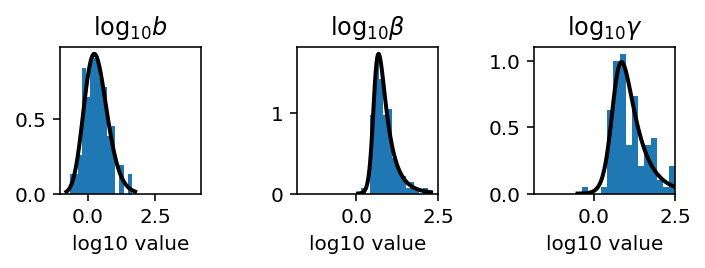

In [ ]:
plot_param_marg(result_data,nosamp=True,fitlaw=norminvgauss)

Examine length dependence (without error bars on maximum likelihood estimates). The full technical noise model does not appear to show much length dependence -- apart from, perhaps, a very modest decrease in burst size. The noise-free model shows that the burst size increases with length.

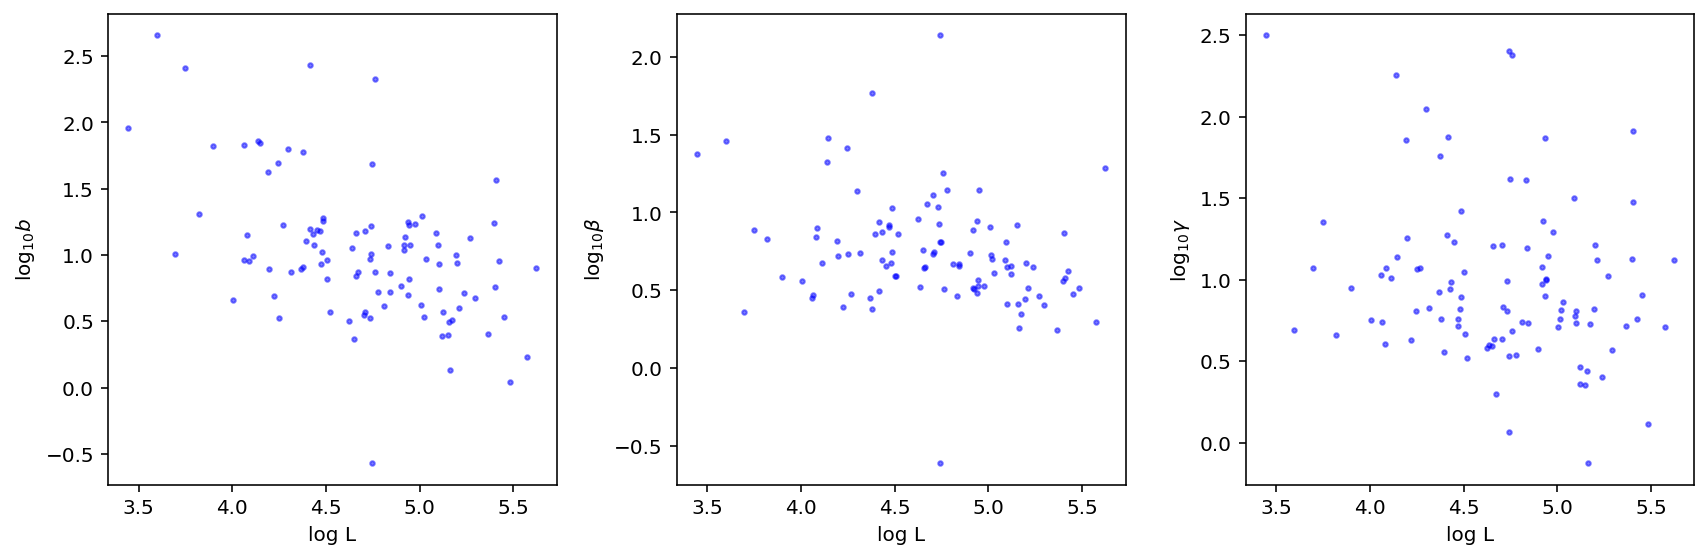

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=False)

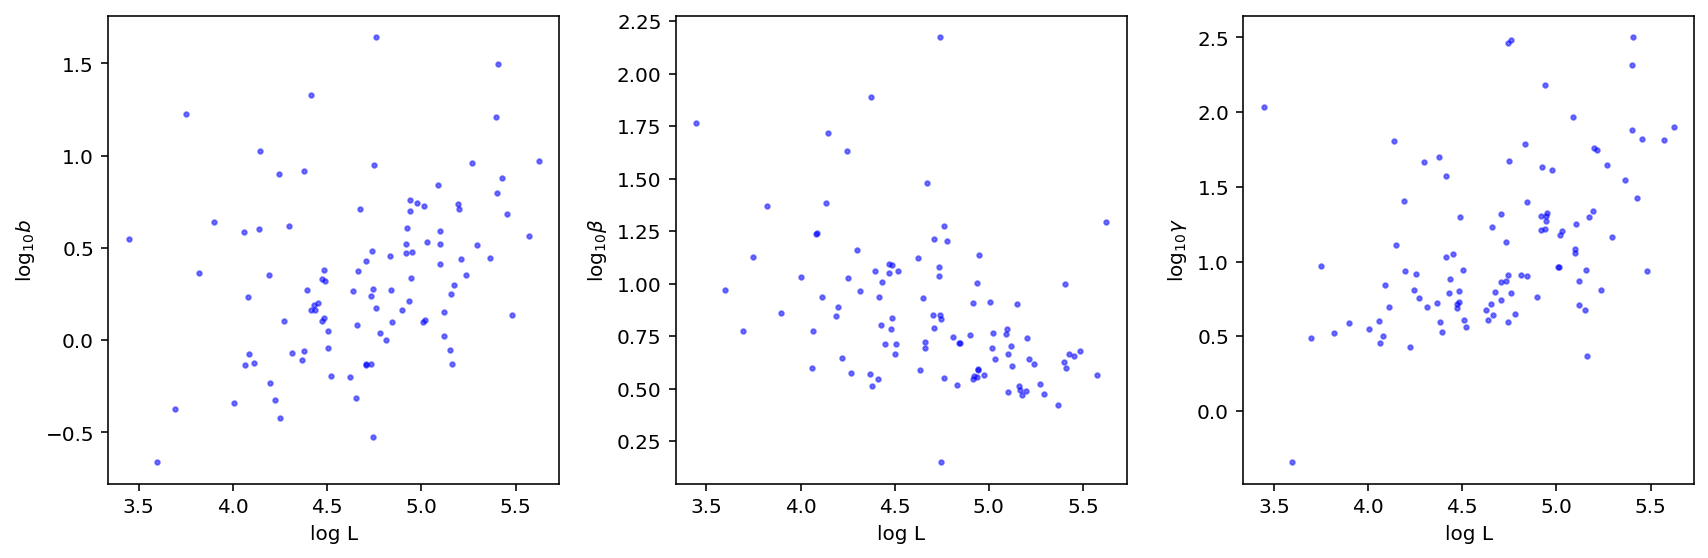

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=False,nosamp=True)

### Fit quality analysis

Investigate the distribution of KL divergences at the optimal grid point. Only a few genes seem to have obviously poor fits (high KL divergence).

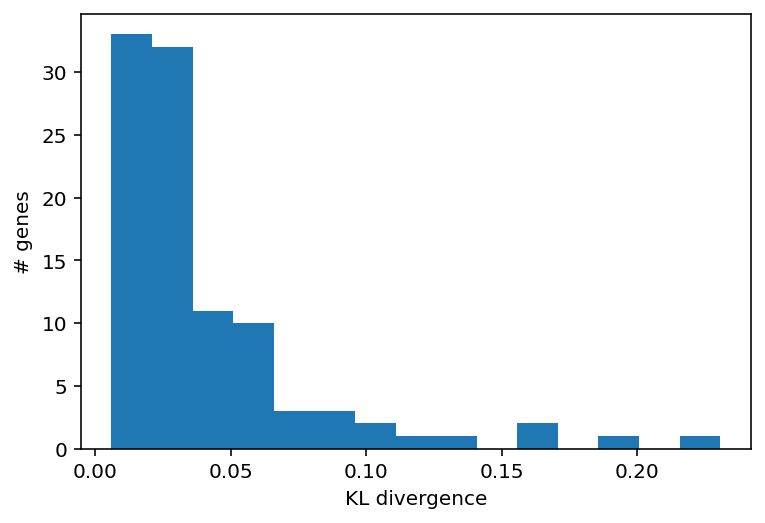

In [ ]:
plot_KL(result_data)

Compute the chi-squared statistic and $p$-values for all genes at the optimal grid point.

In [ ]:
(chisq,pval) = chisq_gen(result_data)

Is the $p$-value higher than 0.05/`n_gen`? The gene is retained. Lower? The gene is rejected due to potential model misspecification.

Output results of the chi-square test in an array corresponding to 1 = rejected, 0 = not rejected.


In [ ]:
sz = (10,10) 
figsize = (10,10)
title=True

In [ ]:
print(np.array(np.reshape(result_data.gene_rej,sz),dtype=int))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [ ]:
print(str(np.sum(result_data.gene_rej))+' genes of '+str(result_data.n_gen)+' have been rejected by chi-square.')

2 genes of 100 have been rejected by chi-square.


Compare the actual raw data to the fits (points: raw data, contour plot: theoretical PMF). The fits seem to accurately reconstruct the molecular distributions. The rejected genes are HSPD1, ATRX, SLU7, COPE, and TCF4.

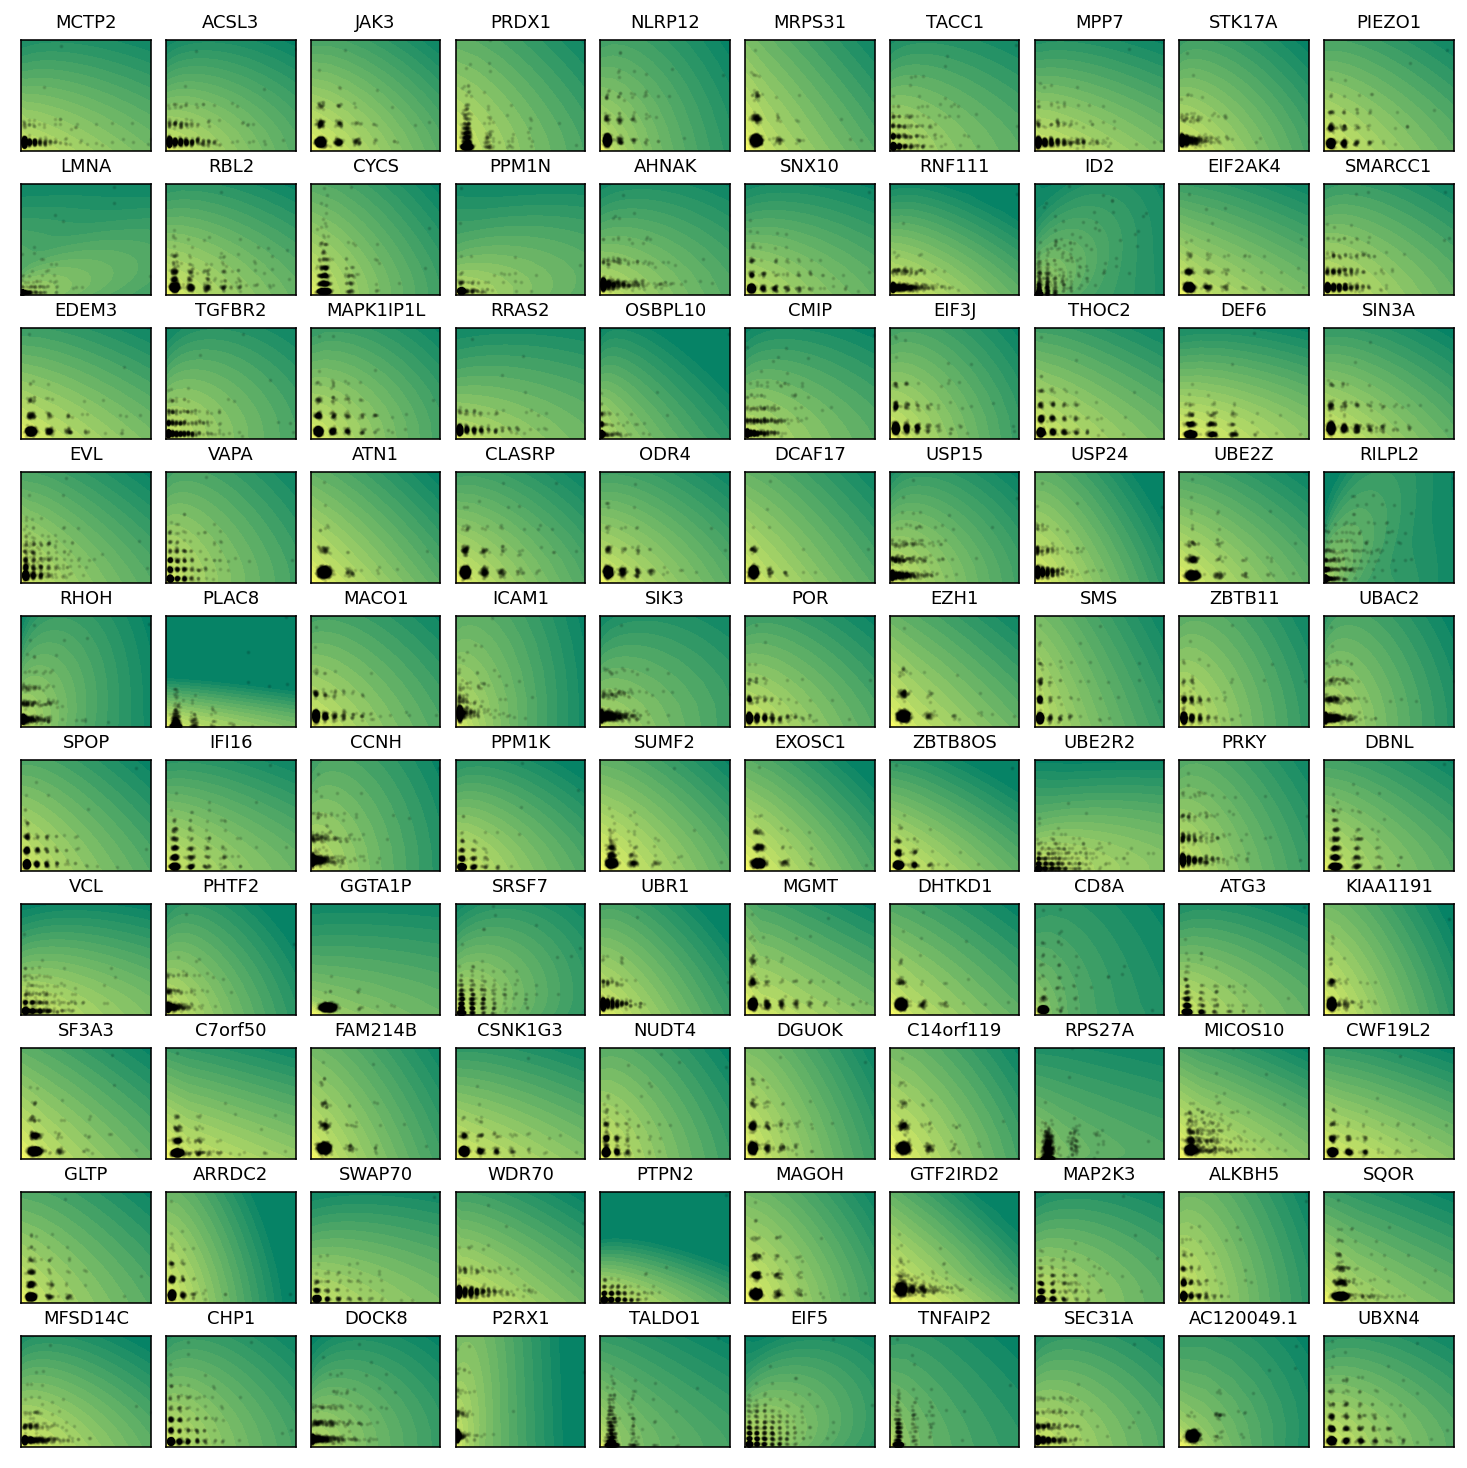

In [ ]:
plot_genes(result_data,sz,figsize,'none',log=True,title=title)

Plot the marginals. Again, the fits appear to be fairly good, although the data are sparse. Note the relatively poor fit to COPE, which supports the choice to reject.

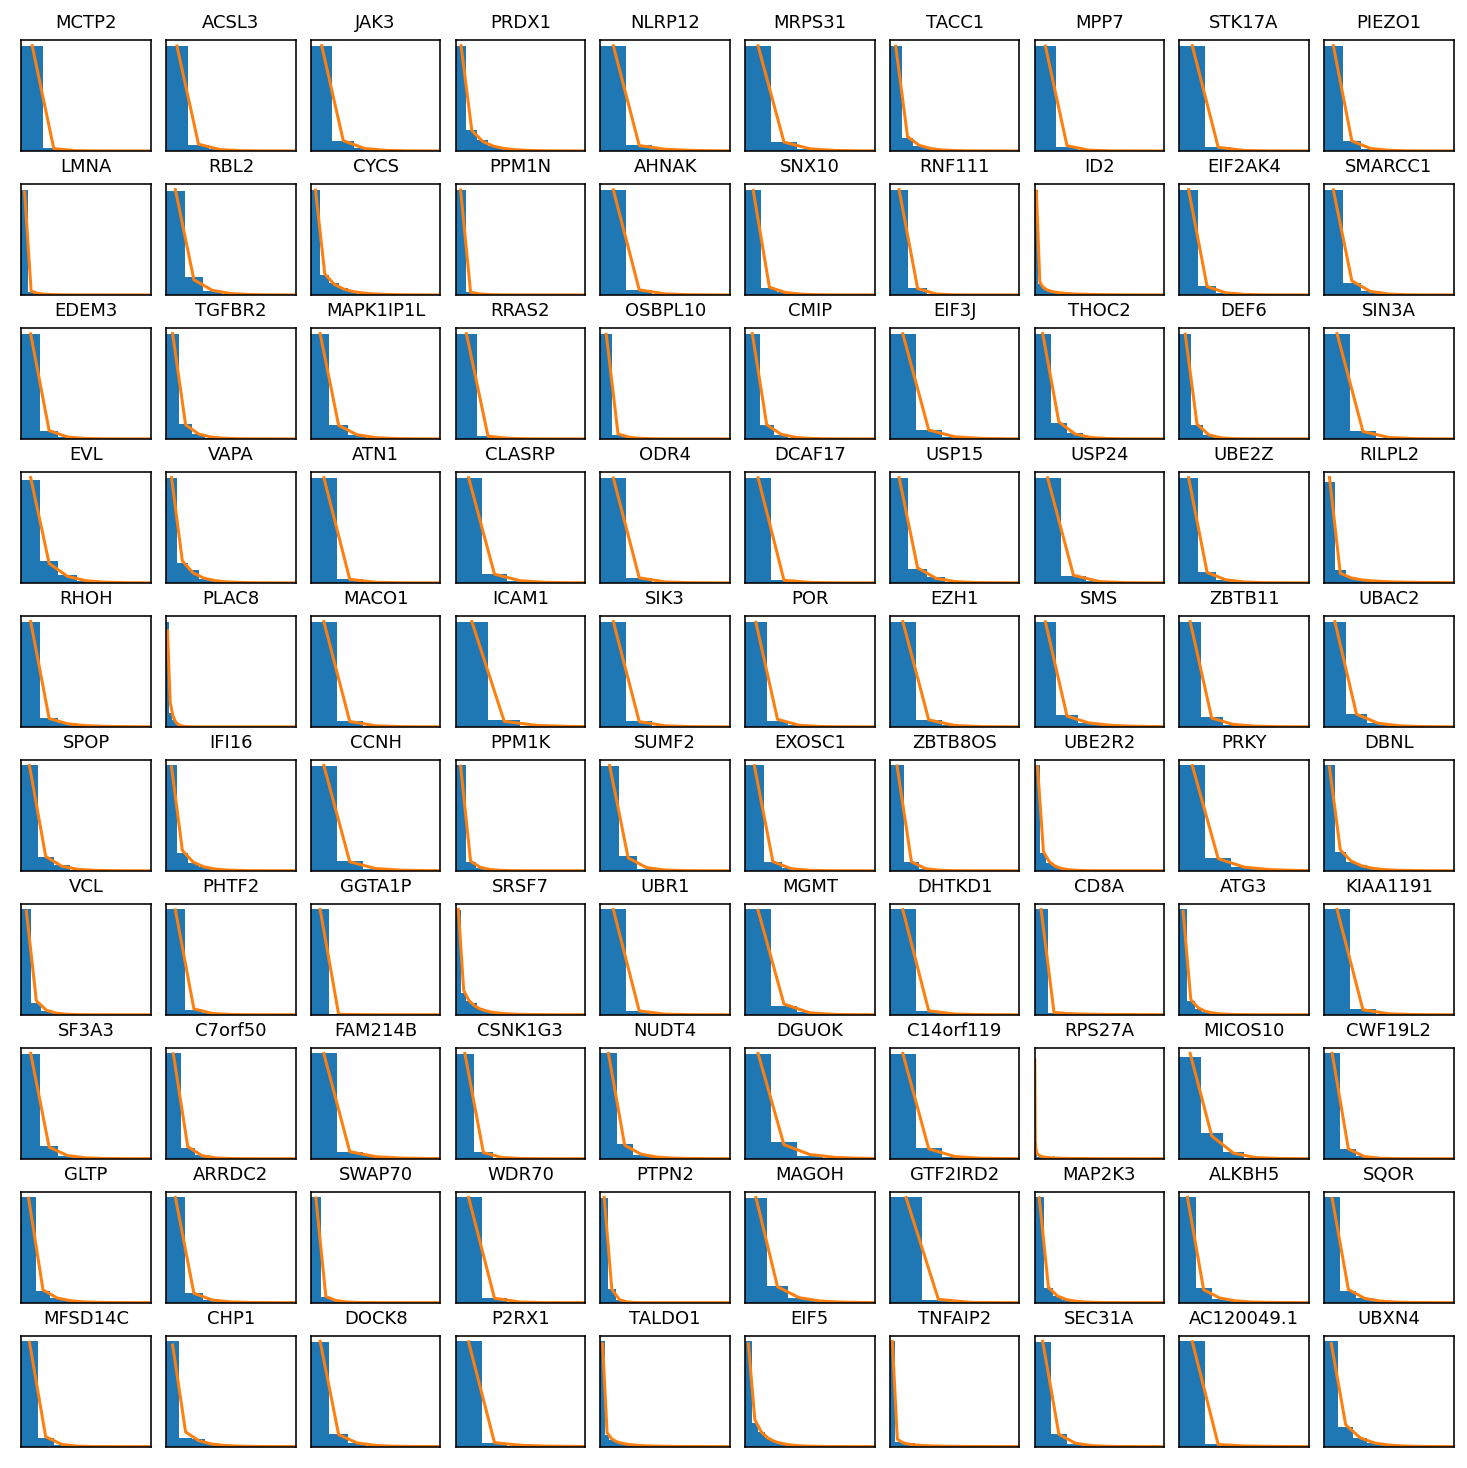

In [ ]:
plot_genes(result_data,sz,figsize,'mature',log=False,title=title)

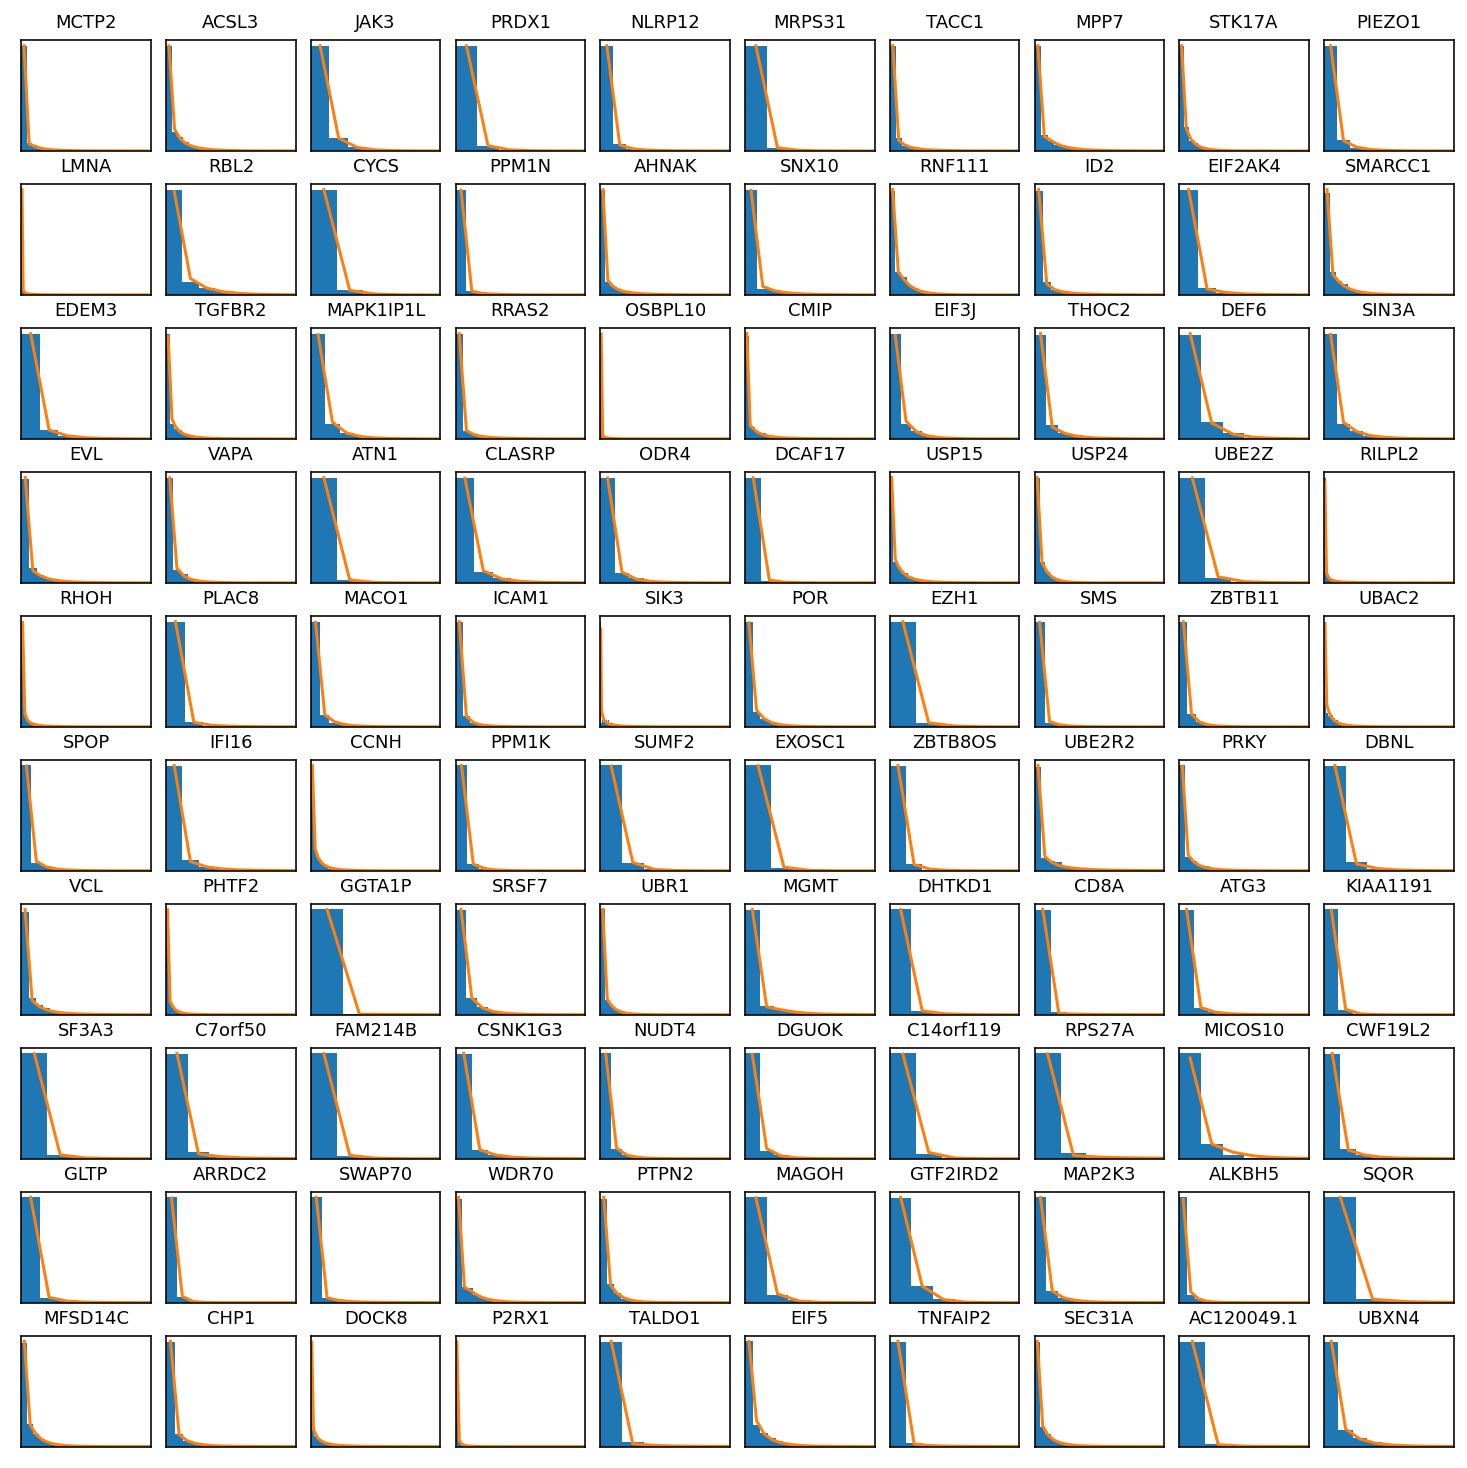

In [ ]:
plot_genes(result_data,sz,figsize,'nascent',log=False,title=title)

Test the stability of the optimum under self-consistent chi-squared testing: reject five genes, recompute the optimum based on all others, repeat. The optimum does not move.

(-5.5, -0.7999999999999998)

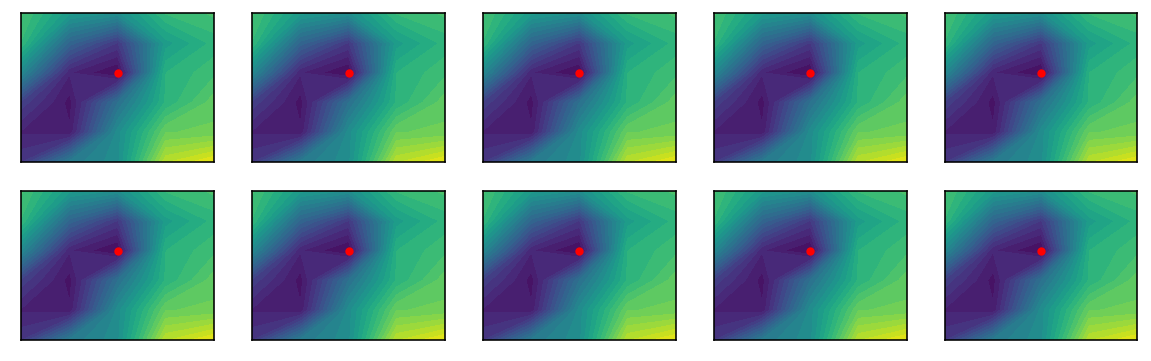

In [ ]:
chisq_best_param_correction(result_data,overwrite=True)

###Confidence interval construction

Compute conditional 99% confidence intervals for MLEs at the optimal grid point. These are fairly narrow, as there are a lot of cells. The genes rejected by the chi-squared test are excluded. We also plot a linear fit to the parameter trends, computed using weighted linear least squares. 

In [ ]:
compute_sigma(result_data)
compute_sigma(result_data,nosamp=True)

/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 87 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 78 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


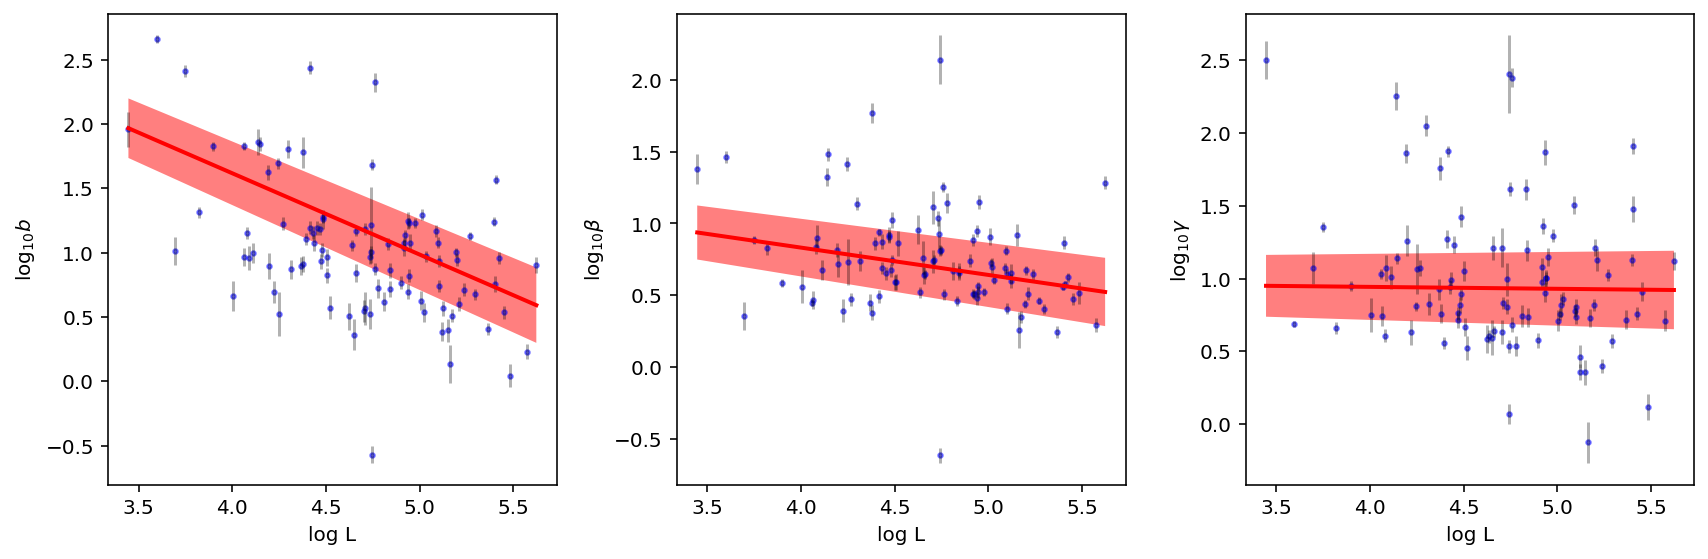

In [ ]:
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=False)

We repeat the procedure for the noise-free fit.

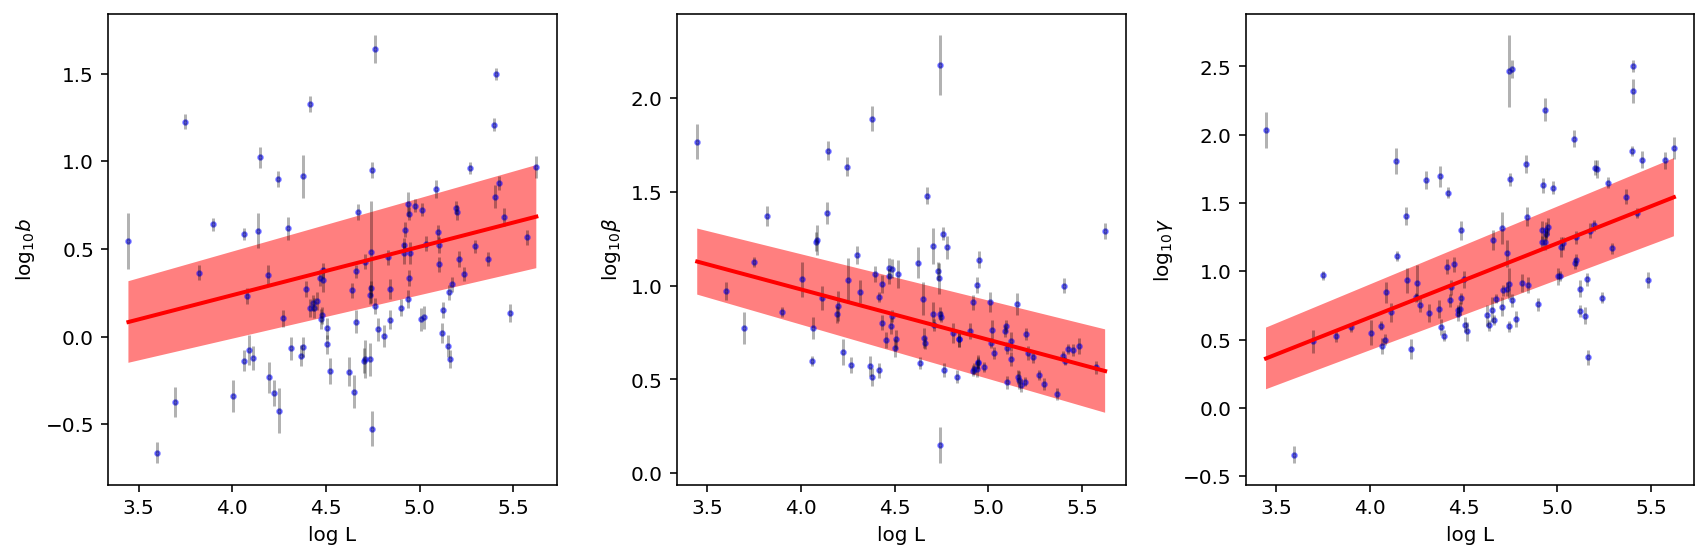

In [ ]:
_=chisq_gen(result_data,nosamp=True)
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=True)

In [ ]:
dt = time.time()-t1
print('{:.0f} seconds elapsed.'.format(dt))

332 seconds elapsed.
